# Sparse Method Algorithm for Research of Transcients Signal

Find transient source in data cubes

F. Acero, T. Stolarczyk, A. Chalumeau, Juin 2018

This notebook will:
1. Simulation (generate_cube_simu)
    - generate the fake data cubes (X,Y,T)
    - Filter the noise in the cubes with different methods
    - Find the peak (burst) in the data
    - Measure how well the methods performed
2. Produce diagnostic and result plots (plot_slice)

3. Produce performance plots based on Monte-Carlo

Some scenarios are considered: 
1. Transcient source position known:
    - Appearing in the FoV : known background
    - Generalist case : background evaluated online
2. Unknown position:
    - Wavelet cleaning

All the code is pure Python with the exception of the denoising step which requires the binary file msvst_2d1d.

In [1]:
%matplotlib inline
import itertools
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
#from matplotlib.colors import Normalize

from gammapy.stats import significance
from gammapy.stats import significance_on_off

from astropy.convolution import convolve,convolve_fft,Gaussian1DKernel,Gaussian2DKernel,Tophat2DKernel
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord,Angle
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table

from scipy.stats import norm
from scipy import interpolate
from scipy.ndimage import zoom

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
import os,subprocess,sys,getpass,copy
import time as systime
import multiprocessing as mp
from functools import partial
from collections import defaultdict

#import line_profiler
#%load_ext line_profiler
#from scipy.stats import chisqprob
#from scipy.special import erfinv,erf,erfcx

import smartcube as smart
import scipy.integrate as sc

In [2]:
### Styles
# Define some plotting parameters and styles
#print(plt.style.available)
#plt.style.use('seaborn-talk')
plt.style.use('fast')

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight']= 'bold'  # weight of the x and y labels
plt.rcParams['figure.titleweight']= 'bold'   # weight of the figure title
plt.rcParams['axes.labelsize']= 15
plt.rcParams['axes.titleweight']='bold'
plt.rcParams['figure.titlesize']= 20
plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.grid'] = True
print('Color used : ',plt.rcParams['axes.prop_cycle'].by_key()['color'])

Color used :  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [4]:
#### Global variables and initialisations
# Path to the binary file - This is lame and adding the binary file to somewhere accesible by $PATH shoud be enough.
#prog='/Users/facero/Documents/Work/CTA/CTA-AIM/code/image-cleaning/msvst/build/msvst_2d1d'

user = getpass.getuser()
print("Defining variables for user",user)
exit
if (user=="achalume"):
    root_dir   = "/Users/achalume/Documents/Stage/Codes/" 
    bin_dir    = "/Users/achalume/Documents/Lib_files/Sparse2D/build/"
elif (user=="stolar"):
    root_dir   = "/home/stolar/Code/" 
    bin_dir    = root_dir + "bin/"
elif (user=="vheyraud"):
    root_dir = ("./")
    bin_dir    = ""

#input_dir  = root_dir + "GRB-Fermi/FAWT3D/FermiData/"
#input_dir = root_dir + "GRB-Fermi/FAWT3D/output/"
#msvst      = bin_dir  + "msvst_2d1d"
#score_dir  = root_dir + "GRB-Fermi/FAWT3D/scores/"
#fig_dir    = root_dir + "GRB-Fermi/FAWT3D/Figures/"

input_dir = "./bin/Monte_Carlo/"#"/local/home/vheyraud/Documents/Valentin/Data/Cubes/On axis/Centered_source_5000_45*45_acceptance1.8_threshold4.5/"##root_dir #"/dev/shm/" 
msvst      = "msvst_2d1d"#bin_dir
score_dir  = root_dir
fig_dir    = root_dir
acceptance_file = "Acceptance-LST-ctapipe.txt"

#### Check existences
if not os.path.exists(input_dir) :
    os.makedirs(input_dir)
if not os.path.exists(fig_dir) :
    os.makedirs(fig_dir)
if not os.path.exists(score_dir) :
    os.makedirs(score_dir)
    
print("Directories :")
print("    - Root              :",root_dir)
print("    - MSVST_2d1d binary :",bin_dir)
print("    - Input             :",input_dir)
print("    - Output            :",input_dir)
print("    - Scores            :",score_dir)
print("    - Figures           :",fig_dir)

Defining variables for user vheyraud
Directories :
    - Root              : ./
    - MSVST_2d1d binary : 
    - Input             : ./bin/Monte_Carlo/
    - Output            : ./bin/Monte_Carlo/
    - Scores            : ./
    - Figures           : ./


# LC function

In [5]:
def LCBinChange(pre_t,pre_LC,fact_T_bin):
    """
    Re-bin a light curve multiplying the initial bin size with fact_T_bin. Returns : new_t,new_LC
    """
    
    alpha = fact_T_bin

    new_t = np.zeros(int(len(pre_t)/alpha)) ; new_LC = np.zeros(len(new_t))
    for i in range(0,len(new_t)):
        new_t[i] = pre_t[int(i*alpha)]
        new_LC[i] = np.sum(pre_LC[int((alpha*i)):int((alpha*i)+alpha)])

    return new_t,new_LC

############################################
def NormLC(LC,value,time,tmin,tmax):
    """
    Norm a range in a light curve (SUM(LC) = value from tmin to tmax). Returns : Normed_LC
    """
    LC_range = LC[np.where((time>=tmin) & (time<=tmax))]
    Normed_LC = value*LC/(np.sum(LC_range))
    
    return Normed_LC
                    
############################################
def InterpFunction(x_val,y_val,x_val_new):
    """
    Interpolate y(x) to get an approached function (y_new) with a given xtable (x_val_new). Returns : y_new
    """
    
    f = interpolate.interp1d(x_val,y_val)
    y_new = f(x_val_new)
    
    return y_new

############################################
def MakeLCTh(timebin,Xi,Tmintot,Tmaxtot,Ntotrange,Tminrange,Tmaxrange):
    """
    Make the theoretical LC normalizing at Ntotrange from Tminrange to Tmaxrange. Returns : Time, LC
    """
    
    T_0 = Tmintot
    Time = np.arange(Tmintot,Tmaxtot+timebin,timebin)
    K = (Tminrange**Xi)*(1+Xi)*Ntotrange/(Tmaxrange**(1+Xi) - Tminrange**(1+Xi))
    LC = K*Tminrange**(-Xi)*((Time)**(Xi+1)-(Time-timebin)**(Xi+1))/(Xi+1)
    
    return Time,LC
############################################
def MakeLCFa(datafile,Timebin,Bin_Factor,Ntotrange,Tminrange,Tmaxrange):
    """
    From Fabio's file, make LC normalizing at Ntotrange from Tminrange to Tmaxrange\
    choosing an initial bin size (Timebin). Returns : Time,LC
    """
    
    TimeData,LCData = np.loadtxt(datafile,unpack=True)
    Time = TimeData - TimeData[0] ; Time_size = TimeData[-1] - TimeData[0]   
    
    # Decrease time bin using an interpolation
    TimeInterp  = [x*Timebin for x in range(0,int(Time_size/Timebin),1)]
    TimeInterp = np.array(TimeInterp)
    LC = InterpFunction(Time,LCData,TimeInterp)
    
    LC_norm = NormLC(LC,Ntotrange,TimeInterp,Tminrange,Tmaxrange)
    T_input,LC_input = LCBinChange(TimeInterp,LC_norm,Bin_Factor) 
    
    return T_input,LC_input

############################################
def MakeLCIn(datafile,Timebin,Bin_Factor,Ntotrange,Tminrange,Tmaxrange):
    """
    From Inoue's extrapolated LC, make LC normalizing at Ntotrange from Tminrange to Tmaxrange.\
    Initial time bin (0.5) taken from the article. Returns : Time, LC
    """
    
    TData,LCData = np.genfromtxt(datafile,unpack=True,skip_header=6)

    # Set time values
    TData_0 = round(TData[0]) ; TData_end = np.round(TData[-1]/Timebin)*(Timebin)
    Time = np.linspace(TData_0,TData_end,len(TData))
    # Set LC values
    LC = LCData * Timebin # Put light curve in counts (it was in Cts/Bin before)
    LC = np.rint(LC).astype(int) # Set counts values

    T_input,LC_input = LCBinChange(Time,LC,Bin_Factor)
    LC_norm = NormLC(LC_input,Ntotrange,T_input,Tminrange,Tmaxrange)

    return T_input,LC_norm


## For results analysis

In [6]:
def ArrValMedian(Arr_val,percent):
    """
    Take an array or list, and if for percent of the cases the list elements aren't NaN, return the median value of the values.
    """
    
    Arr_val = np.array(Arr_val)
    Arr_valsort = np.sort(Arr_val)
    Nth_val = int(percent*len(Arr_valsort))
    Value=np.nan
    if ~np.isnan(Arr_valsort[Nth_val-1]):
        Arr=Arr_valsort
        Value=Arr[int(0.5*len(Arr))]
    
    return Value


def CountsDistribution(LCdict,T_new,t_values,RedFactor,Niterate):
    """
    Input : light curve dictionnary (keys : intensity, iteration index), time list, 
    dictionary of the interesting times (example : time to reach 3sigma) (keys: intensity), intensity and number of iterations
    """
    N=np.full(Niterate,np.nan)
    for i in range(Niterate):
        t=t_values[RedFactor][i]
        LC=LCdict[RedFactor,i]
        if ~np.isnan(t):
            N[i]=LC[np.where(T_new==t)[0][0]]        
    return(N)

def DistanceDistribution(Xdict,Ydict,t_values,RedFactor,Niterate,Xreal,Yreal):
    Distances=[]
    for i in range(Niterate):
        t=t_values[RedFactor][i]
        if ~np.isnan(t):
            X=Xdict[RedFactor,i]
            Y=Ydict[RedFactor,i]
            Distance=pixelsize*np.sqrt((X-Xreal)**2+(Y-Yreal)**2)
            Distances.append(Distance)
        else:
            Distances.append(np.nan)
    return(np.array(Distances))

def BkgDistribution(Bkgdict,T_new,t_values,RedFactor,Niterate,toffgeo,SurfaceOn,method):
    Bkg=np.full(Niterate,np.nan)
    for i in range(Niterate):
        t=t_values[RedFactor][i]
        BkgLC=Bkgdict[RedFactor,i]
        if ~np.isnan(t):
            if method=='ac':
                Bkg[i]=BkgLC[np.where(T_new==t)[0][0]]*(t-(2*T_new[0]-T_new[1])*SurfaceOn/(toffgeo))
            else:
                Bkg[i]=BkgLC[np.where(T_new==t)[0][0]]*SurfaceOn/(toffgeo)
    return(Bkg)

def BkgRateDistribution(Bkgdict,T_new,t_values,RedFactor,Niterate,toffgeo,method):
    BkgRate=np.full(Niterate,np.nan)
    for i in range(Niterate):
        t=t_values[RedFactor][i]
        BkgLC=Bkgdict[RedFactor,i]
        if ~np.isnan(t):
            if method=='ac':
                BkgRate[i]=BkgLC[np.where(T_new==t)[0][0]]/(toffgeo)
            else:
                BkgRate[i]=BkgLC[np.where(T_new==t)[0][0]]/(toffgeo*(t-(2*T_new[0]-T_new[1])))
    return(BkgRate)

def SignalDistribution(LCdict,Bkgdict,T_new,t_values,RedFactor,Niterate,toffgeo,SurfaceOn,method):
    Signal=np.full(Niterate,np.nan)
    for i in range(Niterate):
        t=t_values[RedFactor][i]
        Non=LCdict[RedFactor,i]
        Noff=Bkgdict[RedFactor,i]
        if ~np.isnan(t):
            if method=='ac':
                Signal[i]=Non[np.where(T_new==t)[0][0]]-Noff[np.where(T_new==t)[0][0]]*(t-(2*T_new[0]-T_new[1]))*SurfaceOn/(toffgeo)
            elif method=='wave':
                Signal[i]=Non[np.where(T_new==t)[0][0]]
            else:
                Signal[i]=Non[np.where(T_new==t)[0][0]]-Noff[np.where(T_new==t)[0][0]]*SurfaceOn/(toffgeo)
    return(Signal)
            



## For cubes analysis

In [7]:
def CreateAcceptance(flg,file):
    "flg = 0 : gaussian acceptance with width sigma_vig, flg = 1 interpolated acceptance from file"
    data = Table.read(filename=file,format="ascii")
    theta2 = data["theta2"]
    counts = data["counts"]
    Empirical = interpolate.interp1d(x=theta2,y=counts)
    x = np.linspace(0, n2Dsize-1, n2Dsize)
    y = np.linspace(0, n2Dsize-1, n2Dsize)
    x,y = np.meshgrid(x, y)
    Acceptance=np.empty((n2Dsize,n2Dsize))
    xo,yo=n2Dsize//2,n2Dsize//2
    
    if flg==0:
        Acceptance=np.exp( - ((x-xo)**2+(y-yo)**2)/(2*(sigma_vignetting/pixelsize)**2))
    if flg==1:
        theta2=((x-xo)**2+(y-yo)**2)*pixelsize**2
        theta2[xo,yo]=1# Necessary to avoid an error related to the interpolation error when theta2=0
        Acceptance=Empirical(theta2)
        Acceptance[xo,yo]=1# correct the value at the center
        #Acceptance=Empirical(((x-xo)**2+(y-yo)**2)*pixelsize**2+0.0002) : to use this we must add a small value cause the interpolation isn't defined in 0
    return Acceptance


def ImageRingSignif(Image,meth,FactOffIn,FactOffOut,Xcenter,Ycenter,Theta):
    """
    Returns the significance functions of a "cube image" knowing where is the source ; meth = 'lima', 'simple'
    """
    
    x = np.linspace(0,n2Dsize-1,n2Dsize)
    y = np.linspace(0,n2Dsize-1,n2Dsize)
    x,y = np.meshgrid(x, y)
    
    VignettingOut,VignettingOn = smart.SepSourceBkgImage(Acceptance,Xcenter,Ycenter,Theta)
    VignettingOff = smart.MakeRingImage\
        (Acceptance,Xcenter,Ycenter,FactOffIn,FactOffOut,Theta)
    MeanAcceptanceOn=np.nansum(VignettingOn)/np.size(VignettingOn[np.where(~np.isnan(VignettingOn))])
    MeanAcceptanceOff=np.nansum(VignettingOff)/np.size(VignettingOff[np.where(~np.isnan(VignettingOff))])
    
    ImageOut,ImageOn = smart.SepSourceBkgImage(Image,Xcenter,Ycenter,Theta)
    ImageOff = smart.MakeRingImage(Image,Xcenter,Ycenter,FactOffIn,FactOffOut,Theta)
    
    ton  = np.size(ImageOn[np.where(~np.isnan(ImageOn))])
    toff = np.size(ImageOff[np.where(~np.isnan(ImageOff))])
    alpha = (ton / toff)*(MeanAcceptanceOn / MeanAcceptanceOff)
    
    Non  = np.nansum(ImageOn)
    Noff = np.nansum(ImageOff)
    
    Signif = significance_on_off(n_on=Non,n_off=Noff,alpha=alpha, method=meth)
    return (Signif,Non,Noff,alpha)
############################################

def ImageReflectedSignif(Image,meth,XOn,YOn,Theta):
    """
    Returns the significance functions of a "cube image" knowing where is the source ; meth = 'lima', 'simple'
    """
    
    ImageOut,ImageOn = smart.SepSourceBkgImage(Image,XOn,YOn,Theta)
    Non = np.nansum(ImageOn)
    Xcen = n2Dsize/2 ; Ycen = n2Dsize/2
    DistOn = smart.ImageDistance(XOn,YOn,Xcen,Ycen)
    FactOn=np.arctan2(YOn-Ycen,XOn-Xcen)
    
    d = 5 # distance between 2 circles' centers are 3xradius
    radius = Theta
    Circ = 2*np.pi*DistOn
    NOffRegions = int(Circ/(d*radius))
    ImageOff = {}
    Noff = np.zeros(abs(NOffRegions))
    for i in range(1,NOffRegions+1):  
        Xnew = Xcen + DistOn*np.cos(FactOn+(i*2*np.pi/(NOffRegions+1)))
        Ynew = Xcen + DistOn*np.sin(FactOn+(i*2*np.pi/(NOffRegions+1)))
        ImageOut2,ImageOff[i] = smart.SepSourceBkgImage(Image,Xnew,Ynew,Theta)
        Noff[i-1] = np.nansum(ImageOff[i])
    if NOffRegions==0:
        Signif=0
        Alpha=np.nan
    else:
        Signif = significance_on_off(Non,np.nansum(Noff),alpha=1/NOffRegions,method=meth)
        Alpha=1/NOffRegions
    return (Signif,Non,np.nansum(Noff),Alpha)

##############################################

def Cube2DAnalyse(cube,T_new,method,xsrc,ysrc,factin=3/2,factout=5/2,cubemodel=0,cubebkgac=0,meth='lima'):
    """
    Input : cube (CUMULATED) ; cubebkgacfile or cubemodel (NOT CUMULATED) ; method = 'reflected','ring','ROI vs FOV','acquired bkg'; facton : determines the On area radius, r=facton*psf ; factin : for ring method determine the in-raidus ;
    factout : dertmine th out-radius ; xsrc and ysrc give the source position (for relfected); Xtheta and Ytheta ; meth : significance_on_off gammapy parameter (lima or simple)
    method = 'reflected','ring','ROI vs FOV','acquired bkg','model bkg'
    
    Default values :  factin = 3/2,factout = 5/2, cubemodel=0, cubebkgac=0, meth='lima'
    Public variable called : pixelsize, Tminbkg,Tmaxbkg,Tbinbkg,ROIRadius
    """
    
    Signif,Non,Noff,Alpha = [],[],[],[]
    
    if method=='ring':
        
        for t in range(0,len(cube[0,0,:])):
            Datas=ImageRingSignif(Image=cube[:,:,t],meth=meth,FactOffIn=factin,FactOffOut=factout,Xcenter=xsrc[t],Ycenter=ysrc[t],Theta=ROIRadius/pixelsize)
            Signif.append(Datas[0])
            Non.append(Datas[1])
            Noff.append(Datas[2])

        Alpha = np.full(len(cube[0,0,:]),Datas[3])
                
    elif method=='reflected':
                        
        for t in range(0,len(cube[0,0,:])):
            Datas=ImageReflectedSignif(cube[:,:,t],meth,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            Signif.append(Datas[0])
            Non.append(Datas[1])
            Noff.append(Datas[2])
        Alpha = np.full(len(cube[0,0,:]),Datas[3])
        
    elif method=='ROI vs FOV':
        for t in range(0,len(cube[0,0,:])):
            SourceOut,SourceIn = smart.SepSourceBkgImage(cube,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            Non.append(np.nansum(SourceIn))
            Noff.append(np.nansum(SourceOut))
            Alpha.append(np.size(SourceIn[np.where(~np.isnan(SourceIn))])/np.size(SourceOut[np.where(~np.isnan(SourceOut))]))
        for i in range(len(Noff)):
            if Noff[i]!=0:
                Signif.append(significance_on_off(n_on=Non[i],n_off=Noff[i],alpha=Alpha,method=meth))
            else :
                Signif.append(scipy.stats.norm.ppf(1-0.5*np.exp(-Non[i])))
                      
                        
    elif method=='acquired bkg':
        for t in range(0,len(cube[0,0,:])):                
            SourceOut,SourceIn = smart.SepSourceBkgImage(cube,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            BkgAcOut,BkgAcIn = smart.SepSourceBkgCube(cubebkgac,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            Non.append(np.nansum(SourceIn[:,:,t]))
            Noff.append(np.nansum(BkgAcIn))
            Alpha.append((t+1)*(T_new[1]-T_new[0])/(TmaxBkg-Tminbkg))
        Signif = significance_on_off(n_on=Non,n_off=Noff,alpha=Alpha,method=meth)
        
    elif method=='model bkg':
        for t in range(0,len(cube[0,0,:])):                
            SourceOut,SourceIn = smart.SepSourceBkgImage(cube,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            BkgModelOut,BkgModelIn = smart.SepSourceBkgCube(cubemodel,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            Non.append(np.nansum(SourceIn[:,:,t]))
            Noff.append(np.nansum(BkgModelIn)[:,:,:t])
        for i in range(len(T_new)):
            Alpha.append(1)
        Signif = significance(n_on=Non,mu_bkg=Noff)
    
    elif method=='no bkg':
        for t in range(0,len(cube[0,0,:])):
            SourceOut,SourceIn = smart.SepSourceBkgCube(cube,xsrc[t],ysrc[t],ROIRadius/pixelsize)
            Non.append(np.nansum(SourceIn[:,:,t]))
            Noff.append(0)
            Alpha.append(np.nan)
        for i in range(len(Noff)):
            if Non[i]>nlim:
                Signif.append(100)
            else:
                Signif.append(0)
    Signif=np.array(Signif)
    Non=np.array(Non)
    Noff=np.array(Noff)
    Alpha=np.array(Alpha)
    
    return(Signif,Non,Noff,Alpha)

##############################################


def DiagnosticPlot(SigmaLim,T_new,LC_Src,Signif,Non,Noff,RealSignal,RealBackground,Alpha,shape):

    limit=np.full(len(T_new),SigmaLim)
    fig,ax=plt.subplots(6,figsize=shape)
    ax[0].plot(T_new,Signif,label='LiMa on/off significance',color='forestgreen')
    ax[0].plot(T_new,Signif,'.',color='forestgreen')
    ax[0].plot(T_new,limit,'_',label='Sigma limit',color='black')
    ax[0].legend()
    ax[0].set_title('Significance',fontsize=18)
    ax[1].plot(T_new,Non-Alpha*Noff,label='Signal',color='b')
    ax[1].plot(T_new,Non-Alpha*Noff,'.',color='b')
    ax[1].legend()
    ax[1].set_title('Signal',fontsize=18)
    ax[2].plot(T_new,RealSignal,label='Real Signal',color='black')
    ax[2].plot(T_new,RealSignal,'.',color='black')
    ax[2].legend()
    ax[2].set_title('Real Signal',fontsize=18)
    ax[3].plot(T_new,Alpha*Noff,label='Background',color='r')
    ax[3].plot(T_new,Alpha*Noff,'.',color='r')
    ax[3].legend()
    ax[3].set_title('Background',fontsize=18)                
    ax[4].plot(T_new,RealBkg,label='Real Bkg',color='black')
    ax[4].plot(T_new,RealBkg,'.',color='black')
    ax[4].legend()
    ax[4].set_title('Real Background',fontsize=18)   
    ax[5].plot(T_new,LC_Src,label='Injected signal',color='orange')
    ax[5].plot(T_new,LC_Src,'.',color='orange')
    ax[5].legend()
    ax[5].set_title('Injected Signal',fontsize=18)
    #ax[5].plot(T_new,Non,label='Non',color='green')
    #ax[5].plot(T_new,Non,'.',color='green')
    #ax[5].legend()
    #ax[6].plot(T_new,Noff,label='Noff',color='green')
    #ax[6].plot(T_new,Noff,'.',color='green')
    #ax[6].legend()
    #ax[7].plot(T_new,LC_Src,label='Injected signal',color='orange')
    #ax[7].plot(T_new,LC_Src,'.',color='orange')
    #ax[7].legend()
    plt.tight_layout()
    plt.show()
    print('Alpha = ',Alpha)

#######################################

def SelectTimes(T_new,Signif,SignifMin,RedFactor,N):
    """
    Input : Time, Significance over time for one trial, significance threshold
    Outpout : list of the times for which the significance is over the threshold
    """
    t_min=[]
    for i in range(N):
        Sig=np.array(Signif[RedFactor,i])
        T=T_new[np.where(~np.isnan(Sig))]
        S=Sig[np.where(~np.isnan(Sig))]
        T_good = T[np.where(S>=SignifMin)]
        if T_good.size > 0 : t_min.append(np.min(T_good))
        else : t_min.append(np.float('nan'))
    tmin_values = np.array(t_min)
    
    return(tmin_values)

##########################################################################################

def SearchMax(cube,meth='no smoothing'):
    "Public variable called : sigma_PSF,pixelsize\
    Default method : no smoothing"
    test=copy.deepcopy(cube)
    index_max=np.empty((2,len(cube[0,0,:])))
    if meth=='smoothing':
        for i in range(np.shape(cube)[2]):
            test[:,:,i]=convolve_fft(test[:,:,i],Gaussian2DKernel(sigma_PSF/pixelsize))
    for i in range(np.shape(cube)[2]):
        index_temp=np.unravel_index(np.argmax(test[:,:,i]),np.shape(test[:,:,i]))##return (x_assessed,y_assessed)
        index_max[0,i]=index_temp[1]
        index_max[1,i]=index_temp[0]
    return(index_max)
                        

# My Main

# Instrument response function

In [8]:
FOV               = 4.5    #width in degrees
pixelsize         = 0.1   #in degrees
n2Dsize           = int(FOV/pixelsize)
sigma_vignetting  = 1.8    # (deg) from ctobssim
ct95 = 0.2
a = 0.95
sigma_PSF         = smart.sigma_from_containment_radius(ct95,a)   # (deg) Since the psf isn't a gaussian, we use half of the 95% containement radius and the shape of a gaussian
background        = 0.04    # cts/s/pixel in E=50-500 GeV at center of FoV. Tbin=10s bkg=0.1
sigmaX, sigmaY   = float(sigma_PSF/pixelsize),  float(sigma_PSF/pixelsize) # Point like source
Acceptance=CreateAcceptance(0,acceptance_file)

print("Instrument response function")
print("----------------------------")
print("  Field of view       : ",FOV)
print("  Pixel size          : ",pixelsize)
print("  N. of pixels        : ",n2Dsize,"x",n2Dsize)
print("  Mean CTA background : ",background," (cts/s/pix, 50<E<500 GeV)")



Instrument response function
----------------------------
  Field of view       :  4.5
  Pixel size          :  0.1
  N. of pixels        :  45 x 45
  Mean CTA background :  0.04  (cts/s/pix, 50<E<500 GeV)


# Init : make LC and set source parameters

In [17]:
##################################
# Create 3 LC choosing normalisation range (t_min_norm,t_max_norm) and value (Ntot_norm)
# Each LC and time correspond to a name.
# Timebin[name] = Tbin_input[name]
# Time,LC_Values = T_input[name],LC_input[name]
##################################

LC_input,T_input,t_min_norm,t_max_norm = {},{},{},{} ; Tbin_input = {}

#### Make theoretical LC
Th_name = 'Theoretical'
Tbin_input[Th_name] = 4 # se
xi   = -1.4
t_min_Th = 30 ; t_0_Th = t_min_Th
t_max_Th = 200
Ntot_norm_Th = 1115 # From Inoue (Bkg = 5)
t_min_norm_Th = 50
t_max_norm_Th = 94
T_input[Th_name],LC_input[Th_name] =\
    MakeLCTh(Tbin_input[Th_name],xi,t_min_Th,t_max_Th,Ntot_norm_Th,t_min_norm_Th,t_max_norm_Th)

##################################
# Choose main parameters : Source position and values (list), steady source value, which LC from the 3.
# Then select the differents timeranges from tnew_min until Tnew_max (array)
# Get a dict containing a LC with different sizes
##################################

name = Th_name # Th_name ; Fa_name ; In_name
TimeInput = T_input[name]
LCInput = LC_input[name]
Bkg_input = Tbin_input[name]*background

Tnew_min = 24 
Tmax=174

T_new,LC_new = {},{}
T_new = TimeInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=Tmax))]
LC_new = LCInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=Tmax))]

xcenter, ycenter = 22,22#45,45#10,10#25,25# Position Center of GRB on Image (px,px)
SteadySourcePeak = 0. # Quiescent source - intensity
RedFactorList = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,np.inf]# RedFactorList has to be a list or a tuple # Source intensity factor

print('Src factors = %s\nT_new = %s'%(RedFactorList,T_new))

Src factors = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, inf]
T_new = [ 54  58  62  66  70  74  78  82  86  90  94  98 102 106 110 114 118 122
 126 130 134 138 142 146 150 154 158 162 166 170 174]


# Performances : Monte-Carlo Analysis

In [18]:
### Set method parameters

# Main parameters

Niterate = 400
wav = 1
SignifMin = 3 ; Sigfact = 2
ROIRadius=ct95 #Theta = ct95

# Wavelet parameters

nlim=67

# Ring method parameters

FactRingIn,FactRingOut = 3/2,5/2 # Ring borders distances from circle center : Radius In = FactRingIn*ct95, Radius Out = FactRingOut*ct95

# Known background methods parameters

Tminbkg, Tmaxbkg,Tbinbkg = 0,60,Tbin_input[name]

In [19]:
%%time

### Monte-Carlo simulation 2DAnalysis

RingNon,ReflNon,ModelNon,AcNon,Wave2DNon,Wave2D1DNon,WaveNon = {},{},{},{},{},{},{}
RingNoff,ReflNoff,ModelNoff,AcNoff,Wave2DNoff,Wave2D1DNoff, WaveNoff = {},{},{},{},{},{},{}
RingAlpha,ReflAlpha,AcAlpha,Wave2DAlpha,Wave2D1DAlpha,WaveAlpha = {},{},{},{},{},{}
RingSignif,ReflSignif,ModelSignif,AcSignif,Wave2DSignif,Wave2D1DSignif,WaveSignif = {},{},{},{},{},{},{}
x_smooth,y_smooth={},{}
x_wave,y_wave={},{}
pixmax,pixmax_wave={},{}

for RedFactor in RedFactorList:
    
    for i in range(Niterate):

        ## Read the simulated cubes and create the Wave2Dlet cube
       
        Source = smart.CumulCube(smart.ReadCubeFromFile(input_dir+'FlucTotal_%s_%i.fits'%(RedFactor,i),"fits")[0])
        
        BkgModel= smart.ReadCubeFromFile(input_dir+'ModelBkg_%i_%i.fits'%(Tmax,i),"fits")[0]

        BkgAc = smart.ReadCubeFromFile(input_dir+'AcBkgCube_%i_%i.fits'%(Tmaxbkg-Tminbkg,i),"fits")[0]
        
        Wave2D = smart.ReadCubeFromFile(input_dir+'WavCube2D_%s_%i.fits'%(RedFactor,i),"fits")[0]
        
        ## Recreate the uncumulated Wavelet2D1D filtered cube
        
        #Wave2D1DCumulated,Wave2D1DCube=np.zeros(np.shape(Source)),np.zeros(np.shape(Source))
        
        #for j in range(len(T_new)):
        #    cube_temp=smart.ReadCubeFromFile(input_dir+'WavCube2D1D_%s_%i_%i.fits'%(RedFactor,i,T_new[j]),"fits")[0]
        #    Wave2D1DCumulated[:,:,j]=smart.CumulCube(cube_temp)[:,:,-1]
        #    if j>=1:
        #        Wave2D1DCube[:,:,j]=Wave2D1DCumulated[:,:,j]-Wave2D1DCumulated[:,:,j-1]
        
        ## Recreate the uncumulated Wavelet 2D (not PyWi) cube
        
        #WaveCumulated,WaveCube=np.zeros(np.shape(Source)),np.zeros(np.shape(Source))
        
        #for j in range(len(T_new)):
        #    cube_temp=smart.ReadCubeFromFile(input_dir+'WavCube_%s_%i_%i.fits'%(RedFactor,i,T_new[j]),"fits")[0]
        #    WaveCumulated[:,:,j]=cube_temp
        #    if j>=1:
        #        WaveCube[:,:,j]=WaveCumulated[:,:,j]-WaveCumulated[:,:,j-1]
        #
        
        ## Compute the results from the cubes

        pixmax[RedFactor,i]=SearchMax(Source,meth='smoothing')
        #pixmax_wave[RedFactor,i]=SearchMax(Wave2D)
               
        x_smooth[RedFactor,i],y_smooth[RedFactor,i]=np.full(len(T_new),xcenter),np.full(len(T_new),ycenter)#pixmax[RedFactor,i][0],pixmax[RedFactor,i][1]#
        x_wave[RedFactor,i],y_wave[RedFactor,i]=np.full(len(T_new),xcenter),np.full(len(T_new),ycenter)#pixmax[RedFactor,i][0],pixmax[RedFactor,i][1]#pixmax_wave[RedFactor,i][0],pixmax_wave[RedFactor,i][1]#
        
        Ring = Cube2DAnalyse(Source,T_new,method='ring',xsrc=x_smooth[RedFactor,i],ysrc=y_smooth[RedFactor,i])
        RingSignif[RedFactor,i],RingNon[RedFactor,i],RingNoff[RedFactor,i],RingAlpha = Ring[0],Ring[1],Ring[2],Ring[3]
        Wave2D = Cube2DAnalyse(Wave2D,T_new,method='no bkg',xsrc=x_wave[RedFactor,i],ysrc=y_wave[RedFactor,i]) 
        Wave2DSignif[RedFactor,i],Wave2DNon[RedFactor,i],Wave2DNoff[RedFactor,i],Wave2DAlpha = Wave2D[0],Wave2D[1],Wave2D[2],Wave2D[3]
  
        #Wave2D1D = Cube2DAnalyse(Wave2D1DCumulated,method='ROI vs FOV') 
        #Wave2D1DSignif[RedFactor,i],Wave2D1DNon[RedFactor,i],Wave2D1DNoff[RedFactor,i],Wave2D1DAlpha = Wave2D1D[0],Wave2D1D[1],Wave2D1D[2],Wave2D1D[3]
          
            
        #Refl = Cube2DAnalyse(Source,T_new,method='reflected',xsrc=x_smooth[RedFactor,i],ysrc=y_smooth[RedFactor,i])             
        #ReflSignif[RedFactor,i],ReflNon[RedFactor,i],ReflNoff[RedFactor,i],ReflAlpha = Refl[0],Refl[1],Refl[2],Refl[3]
        
        #Model = Cube2DAnalyse(Source,T_new,method='model bkg',cubemodel=BkgModel,Tmaxbkg=T_new[-1],Tminbkg=2*T_new[0]-T_new[1],xsrc=x_smooth[RedFactor,i],ysrc=y_smooth[RedFactor,i])
        #ModelSignif[RedFactor,i],ModelNon[RedFactor,i],ModelNoff[RedFactor,i],ModelAlpha = Model[0],Model[1],Model[2],Model[3]
        #
        #Ac = Cube2DAnalyse(Source,T_new,cubebkgac=BkgAc,method='acquired bkg',xsrc=x_smooth[RedFactor,i],ysrc=y_smooth[RedFactor,i])
        #AcSignif[RedFactor,i],AcNon[RedFactor,i],AcNoff[RedFactor,i],AcAlpha = Ac[0],Ac[1],Ac[2],Ac[3]
        
        print(i+1,'done in',Niterate,' ; ',RedFactor,'done in',RedFactorList,end='\r')

/local/home/vheyraud/anaconda3/lib/python3.6/site-packages/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in log
  ll = n_on * np.log(n_on * tt / alpha)
/local/home/vheyraud/anaconda3/lib/python3.6/site-packages/gammapy/stats/poisson.py:383: RuntimeWarning: invalid value encountered in multiply
  ll = n_on * np.log(n_on * tt / alpha)


/local/home/vheyraud/anaconda3/lib/python3.6/site-packages/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  mm = n_off * np.log(n_off * tt)
/local/home/vheyraud/anaconda3/lib/python3.6/site-packages/gammapy/stats/poisson.py:384: RuntimeWarning: invalid value encountered in multiply
  mm = n_off * np.log(n_off * tt)


CPU times: user 41min 38s, sys: 28.3 s, total: 42min 6s30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, inf]
Wall time: 21min 7s


# Results analysis

In [20]:
## Create the lists of the times for which 3 sigma is reached

tmin_values_model, tmin_values_ac, tmin_values_ring, tmin_values_refl, tmin_values_wave = {},{},{},{},{}

for RedFactor in RedFactorList:
    tmin_values_wave[RedFactor]=SelectTimes(Signif=Wave2DSignif,SignifMin=SignifMin,T_new=T_new,RedFactor=RedFactor,N=Niterate)
    #tmin_values_refl[RedFactor]=SelectTimes(Signif=ReflSignif,SignifMin=SignifMin,T_new=T_new,RedFactor=RedFactor,N=Niterate)
    tmin_values_ring[RedFactor]=SelectTimes(Signif=RingSignif,SignifMin=SignifMin,T_new=T_new,RedFactor=RedFactor,N=Niterate)
    #tmin_values_ac[RedFactor]=SelectTimes(Signif=AcSignif,SignifMin=SignifMin,T_new=T_new,RedFactor=RedFactor,N=Niterate)
    #tmin_values_model[RedFactor]=SelectTimes(Signif=ModelSignif,SignifMin=SignifMin,T_new=T_new,RedFactor=RedFactor,N=Niterate)
        
###Create the lists of the median times to reach 3sigma in cases of success

Valtmed_model,Valtmed_ac,Valtmed_refl,Valtmed_ring,Valtmed_wave,Valtmed_wave_classic  = [],[],[],[],[],[]
# DetectionPerc will be the (perc)% best value to get SignifMin as early as possible
perc = 0.90

Timemin = np.min(T_new) #To begin time values at 0 (y-axe) (Not counting the time from the alert and slewing)

for RedFactor in RedFactorList:
    #Valtmed_model.append(ArrValMedian(tmin_values_model[RedFactor],perc)-(Timemin-Tbin_input[name]))
    #Valtmed_ac.append(ArrValMedian(tmin_values_ac[RedFactor],perc)-(Timemin-Tbin_input[name]))
    #Valtmed_refl.append(ArrValMedian(tmin_values_refl[RedFactor],perc)-(Timemin-Tbin_input[name]))
    Valtmed_ring.append(ArrValMedian(tmin_values_ring[RedFactor],perc)-(Timemin-Tbin_input[name]))  
    Valtmed_wave.append(ArrValMedian(tmin_values_wave[RedFactor],perc)-(Timemin-Tbin_input[name]))


In [21]:
I=[]
for i in range(Niterate):
    if np.max(Wave2DNon[np.inf,i])<1:
        I.append(i)
print(len(I)/Niterate*100)

0.0


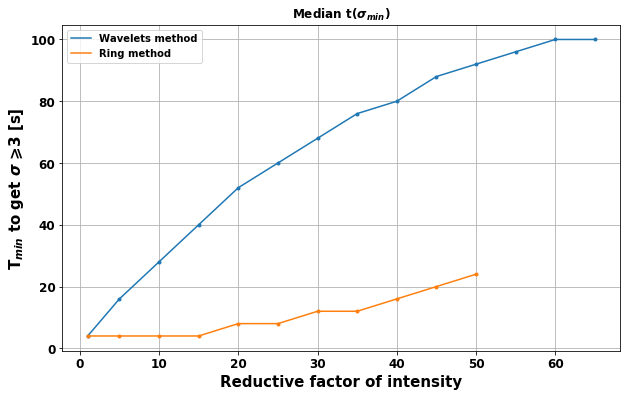

In [22]:
## Plot the median t3sigma for successes as a function of the source intensity, for each method
idbg = 1

if idbg == 1:

    fig, (ax) = plt.subplots(figsize=(10,6))
    #ax.plot(np.array(RedFactorList),Valtmed_model,label='Perfectly known background')
    #ax.plot(np.array(RedFactorList),Valtmed_model,'.',color='r')
    #ax.plot(np.array(RedFactorList),Valtmed_ac,label='Acquired background',color='b')
    #ax.plot(np.array(RedFactorList),Valtmed_ac,'.',color='b')
    ax.plot(np.array(RedFactorList),Valtmed_wave,label='Wavelets method')
    ax.plot(np.array(RedFactorList),Valtmed_wave,'.',color='#1f77b4')
    #ax.plot(np.array(RedFactorList),Valtmed_refl,label='Reflected method',color='dodgerblue')
    #ax.plot(np.array(RedFactorList),Valtmed_refl,'.',color='dodgerblue')
    ax.plot(np.array(RedFactorList),Valtmed_ring,label='Ring method')
    ax.plot(np.array(RedFactorList),Valtmed_ring,'.',color='#ff7f0e')

    ax.set_xlabel('Reductive factor of intensity',fontsize=15)
    ax.set_ylabel('T$_{min}$ to get $\sigma$ $\geqslant$3 [s]',fontsize=15)
    #ax.set_xscale('log')
    #text =  '$\sigma_{min}$               = %s\n'\
    #    'T$_{bin}$                = %s s\n'\
    #    'I$_{Steady Src}$ max = %s\n'\
    #    'x$_{cen}$, y$_{cen}$       = %s px, %s px\n'\
    #    '\nSignificance methods parameters :\n'\
    #    '        N $\sigma_{PSF}$        = %s\n'\
    #    %(SignifMin,Tbin_input[name],SteadySourcePeak,xcenter,ycenter,Sigfact)
    #ax.text(1.05,0.3,text, dict(size=12), transform = ax.transAxes,\
    #                                    bbox=dict(facecolor='white', alpha=0.5))
    ax.set_title('Median t($\sigma_{min}$)')
    plt.savefig('./MedianTimesResults_CenteredSource.png')
    plt.legend()
    plt.show()

In [23]:
###Create the lists of the percentage of success for each method

DetectionPerc_model,DetectionPerc_ac,DetectionPerc_refl,DetectionPerc_ring,DetectionPerc_wave,DetectionPerc_wave_classic  = [],[],[],[],[],[]
# DetectionPerc will be the (perc)% best value to get SignifMin as early as possible

for RedFactor in RedFactorList:
    #DetectionPerc_model.append(len(np.where(~np.isnan(tmin_values_model[RedFactor]))[0])/Niterate*100)
    #DetectionPerc_ac.append(len(np.where(~np.isnan(tmin_values_ac[RedFactor]))[0])/Niterate*100)
    #DetectionPerc_refl.append(len(np.where(~np.isnan(tmin_values_refl[RedFactor]))[0])/Niterate*100)
    DetectionPerc_ring.append(len(np.where(~np.isnan(tmin_values_ring[RedFactor]))[0])/Niterate*100)
    DetectionPerc_wave.append(len(np.where(~np.isnan(tmin_values_wave[RedFactor]))[0])/Niterate*100)
   

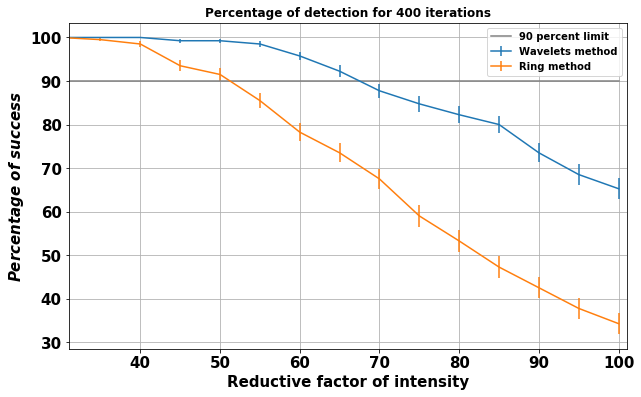

False positives : 
 Ring method :  1.0 %
 Wavelet method :  6.0 %


In [24]:
## Plot the percentage of success for each method as a function of the source intensity
idbg = 1

if idbg == 1:

    fig, ax = plt.subplots(figsize=(10,6))
    #ax.plot(np.array(RedFactorList),DetectionPerc_model,label='Perfectly known background')
    #ax.plot(np.array(RedFactorList),DetectionPerc_model,'.',color='r')
    #ax.plot(np.array(RedFactorList),DetectionPerc_ac,label='Acquired background',color='b')
    #ax.plot(np.array(RedFactorList),DetectionPerc_ac,'.',color='b')
    ax.errorbar(np.array(RedFactorList),DetectionPerc_wave,yerr=100*np.sqrt(np.array(DetectionPerc_wave)/100*(1-np.array(DetectionPerc_wave)/100)/Niterate),label='Wavelets method')
    #ax.errorbar(np.array(RedFactorList),DetectionPerc_refl,yerr=100*np.sqrt(np.array(DetectionPerc_refl)/100*(1-np.array(DetectionPerc_refl)/100)/Niterate),color='dodgerblue',label='Wavelets method')
    ax.errorbar(np.array(RedFactorList),DetectionPerc_ring,yerr=100*np.sqrt(np.array(DetectionPerc_ring)/100*(1-np.array(DetectionPerc_ring)/100)/Niterate),label='Ring method')
    ax.set_xlabel('Reductive factor of intensity',fontsize=15)
    ax.plot(np.array(RedFactorList),np.full(len(np.array(RedFactorList)),90),'-',label='90 percent limit',color='grey')
    ax.set_ylabel('$Percentage$ $of$ $success$')
    ax.set_xscale('linear')
    text =  '$\sigma_{min}$               = %s\n'\
        'T$_{bin}$                = %s s\n'\
        'I$_{Steady Src}$ max = %s\n'\
        'x$_{cen}$, y$_{cen}$       = %s px, %s px\n'\
        '\nSignificance methods parameters :\n'\
        '        N $\sigma_{PSF}$        = %s\n'\
        %(SignifMin,Tbin_input[name],SteadySourcePeak,xcenter,ycenter,Sigfact)
    #ax.text(1.05,0.3,text, dict(size=12), transform = ax.transAxes,\
                                        #bbox=dict(facecolor='white', alpha=0.5))
    ax.set_title('Percentage of detection for %s iterations'%(Niterate))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim(31,101)
    plt.savefig('./PercentageOfSuccess_CenteredSource.png')
    plt.legend()
    plt.show()
    print('False positives : \n Ring method : ',DetectionPerc_ring[-1],'%\n Wavelet method : ',DetectionPerc_wave[-1],'%')

In [135]:
## Plot the assessed position in time in the case of a detection
RedFact=80
distance_lim=2

fig=plt.figure(figsize=(10,7))


PixIndice, TrialIndice = [],[]
for i in range(Niterate):
    if np.max(RingSignif[RedFact,i])>=3:
        TrialIndice.append(i)
data_arr=np.empty((len(T_new),len(TrialIndice)))

for j in range(len(TrialIndice)):
    data_arr[:,j]=np.sqrt((pixmax[RedFact,TrialIndice[j]][0]-xcenter)**2+(pixmax[RedFact,TrialIndice[j]][1]-ycenter)**2)
    #plt.scatter(T_new,data_arr[:,j],color='#1f77b4')
for t in range(len(T_new)):
    plt.errorbar(x=T_new,y=np.mean(data_arr,axis=1),yerr=np.std(data_arr,axis=1),linestyle='None',marker='.',color='#1f77b4')
plt.plot(T_new,np.full(len(T_new),distance_lim),color='grey')
plt.ylabel('Distance to the center')
plt.xlabel('Observation time (s)')
plt.show()
plt.savefig('./Assessed_position_distribution.pdf')


KeyError: (80, 0)

<Figure size 720x504 with 0 Axes>

In [ ]:
## Plot the assessed position in time
RedFact=80
distance_lim=2

fig=plt.figure(figsize=(10,7))
data_arr=np.empty((len(T_new),Niterate))

for i in range(Niterate):
    data_arr[:,i]=np.sqrt((pixmax[RedFact,i][0]-xcenter)**2+(pixmax[RedFact,i][1]-ycenter)**2)
    #plt.scatter(T_new,data_arr[:,i],color='#1f77b4')
for t in range(len(T_new)):
    plt.errorbar(x=T_new,y=np.mean(data_arr,axis=1),yerr=np.std(data_arr,axis=1),linestyle='None',marker='.',color='#1f77b4')
plt.plot(T_new,np.full(len(T_new),distance_lim),color='grey')
plt.ylabel('Distance to the center')
plt.xlabel('Observation time (s)')
plt.show()
plt.savefig('./Assessed_position_distribution.pdf')


In [ ]:
## Show the results of a gaussian smoothing on a cube

RedFact=np.inf
i=np.random.randint(400)
test= smart.CumulCube(smart.ReadCubeFromFile(input_dir+'FlucTotal_%s_%i.fits'%(RedFact,i),"fits")[0])
for i in range(len(test[0,0,:])):
    test[:,:,i]=convolve_fft(test[:,:,i],Gaussian2DKernel(ct95/2/pixelsize))
smart.PlotCubeImage(2,'',test,T_new,54,4)

t3s=np.where(RingSignif[RedFact,i]>=3)[0]
print('x3s = ',pixmax[RedFact,i][0][t3s],', y3s = ',pixmax[RedFact,i][1][t3s])
print('Detection times : ',T_new[t3s])


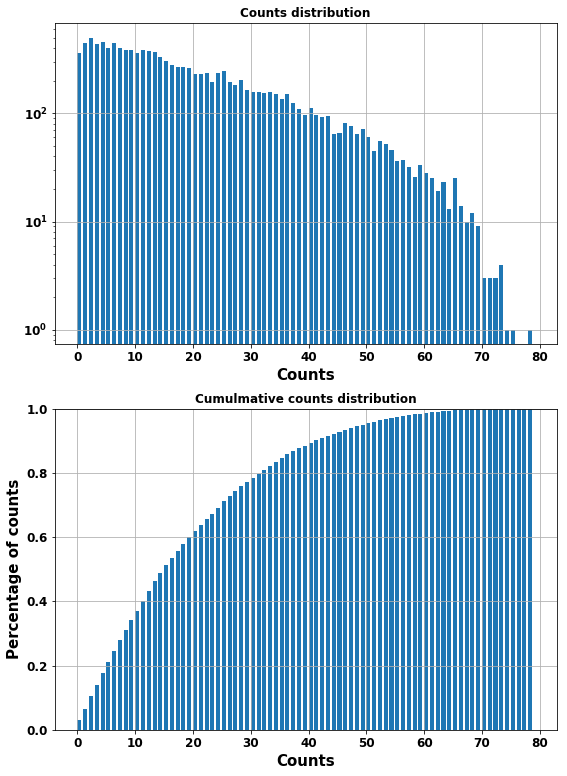

In [14]:
## Plot the Non distribution in time for pure noise

data_arr=np.empty((len(T_new),Niterate))
for i in range(Niterate):
    data_arr[:,i]=Wave2DNon[np.inf,i]

data=data_arr.flatten()
nmax=int(np.max(data))+1
nbins=nmax

fig,(ax1,ax2)=plt.subplots(2,figsize=(9,13))

ax1.hist(data,bins=np.linspace(0,nmax,nbins+1),width=0.7)
ax1.set_yscale('log')
ax1.set_title('Counts distribution')
ax1.set_xlabel('Counts')
ax1.set_ylabel('')
ax2.set_title('Cumulmative counts distribution')
ax2.set_ylim(0,1)
ax2.set_ylabel('Percentage of counts')
ax2.set_xlabel('Counts')
ax2.hist(data,bins=np.linspace(0,nmax,nbins+1),density=True,cumulative=True,width=0.7)
plt.savefig('./Distribution_false_positives.png')

print()

79


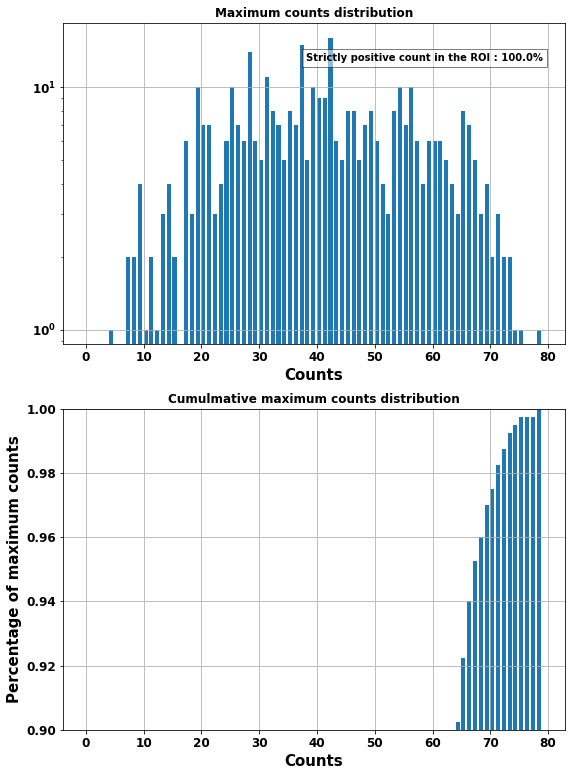

In [15]:
## Plot the distribution of the maximum number of counts in the ROI over each trial

data_arr=np.empty(Niterate)

for i in range(Niterate):
    data_arr[i]=np.max(Wave2DNon[np.inf,i])

data=data_arr.flatten()
nmax=int(np.max(data))+1
nbins=nmax
print(int(nbins))

fig,(ax1,ax2)=plt.subplots(2,figsize=(9,13))

ax1.hist(data,bins=np.linspace(0,nmax,nbins+1),width=0.7)
ax1.set_yscale('log')
ax1.set_title('Maximum counts distribution')
ax1.set_xlabel('Counts')
ax1.set_ylabel('')
ax2.set_title('Cumulmative maximum counts distribution')
#ax2.set_yscale('log')
ax2.set_ylim(0.9,1)
ax2.set_ylabel('Percentage of maximum counts')
fig.text(0.5,0.84,'Strictly positive count in the ROI : '+str(100*len(data[np.where(data>0)])/Niterate)+'%',bbox=dict(facecolor='white', alpha=0.5))
ax2.set_xlabel('Counts')
ax2.hist(data,bins=np.linspace(0,nmax,nbins+1),density=True,cumulative=True,width=0.7,align='mid')
plt.savefig('./Distribution_false_positives_maximums.png')

In [124]:
p=0.94
N=400
delta_p=np.sqrt(p*(1-p)/N)
CI=[p-3*delta_p,p+3*delta_p]
print(CI)



[0.9043769737388861, 0.9756230262611137]


In [56]:
100*np.sqrt(0.0875*(1-0.0875)/400)

1.4128318194321643

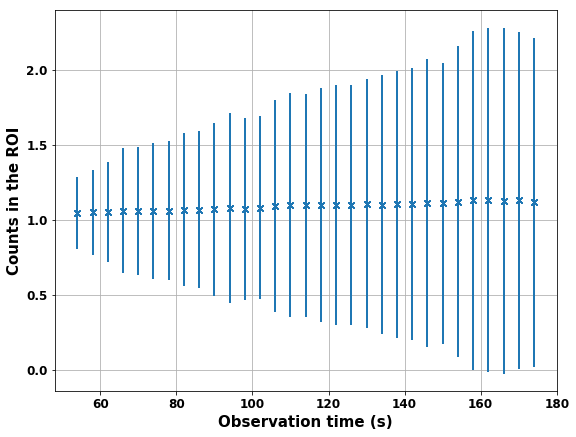

In [57]:
## Plot the differents values of Non as a function of time

fig=plt.figure(figsize=(9,7))

data_arr=np.empty((len(T_new),Niterate))

nsmc=[]
ntemp=0
for i in range(Niterate):
    data_arr[:,i]=Wave2DNon[np.inf,i]
    #plt.scatter(T_new,data_arr[:,i],color='#1f77b4')
    
for t in range(len(T_new)):
    plt.errorbar(x=T_new,y=np.add(1,np.mean(data_arr,axis=1)),yerr=np.std(data_arr,axis=1),linestyle='None',marker='x',color='#1f77b4')
plt.ylabel('Counts in the ROI')
plt.xlabel('Observation time (s)')

plt.savefig('./Counts_in_ROI_distribution.png')


In [58]:
## Plot examples of filtered pure noise cubes with a strictly positive number of counts in the ROI

x = np.linspace(0,n2Dsize-1,n2Dsize)
y = np.linspace(0,n2Dsize-1,n2Dsize)
x,y = np.meshgrid(x, y)

xc,yc=22,22
radius=ct95/pixelsize

Image = np.zeros((45,45))
ImageOff = smart.MakeRingImage(Image,xc,yc,3/2,5/2,ct95/pixelsize)
ImageOn = smart.SepSourceBkgImage(Image=Image,theta=radius,x_src=xc,y_src=yc)[1]
Image[np.where(~np.isnan(ImageOn))]=0.02
I=[]
for i in range(400):
    if np.max(Wave2DNon[np.inf,i])!=0:
        I.append(i)
print(len(I))
test=smart.ReadCubeFromFile(input_dir+'WavCube2D_%s_%i.fits'%(np.inf,I[np.random.randint(len(I))]),"fits")[0]#126
for t in range(len(test[0,0,:])):
    test[:,:,t]=test[:,:,t]-Image
smart.PlotCubeImage(2,'',test,T_new,54,4)

66



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

In [59]:
## Plot the positions where wavelets find a signal

RedFactor=np.inf
x = np.linspace(0,n2Dsize-1,n2Dsize)
y = np.linspace(0,n2Dsize-1,n2Dsize)
x,y = np.meshgrid(x, y)

xc,yc=22,22
radius=ct95/pixelsize

NbCounts = np.zeros((45,45,len(T_new)))
AvgIntensity = np.zeros((45,45,len(T_new)))
for i in range(400):
    temp=smart.ReadCubeFromFile(input_dir+'WavCube2D_%s_%i.fits'%(RedFactor,i),"fits")[0]
    for t in range(len(T_new)):
        AvgIntensity[:,:,t]=AvgIntensity[:,:,t]+temp[:,:,t]
        temp[:,:,t][np.where(temp[:,:,t]!=0)]=1
        NbCounts[:,:,t]=NbCounts[:,:,t]+temp[:,:,t]
for i in range(len(T_new)):
    AvgIntensity[:,:,t]=AvgIntensity[:,:,t]/NbCounts[:,:,t]
print("Positions found after filtering (number of time a pixel is found)")
smart.PlotCubeImage(2,'',C,T_new,54,4)
print("Mean intensity pixel by pixel over %i iterations"%(Niterate))
smart.PlotCubeImage(2,'',AvgIntensity,T_new,54,4)

Positions found after filtering (number of time a pixel is found)


/local/home/vheyraud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'C' is not defined

In [ ]:
##Calculate Ring surface and ROI surface

x = np.linspace(0,n2Dsize-1,n2Dsize)
y = np.linspace(0,n2Dsize-1,n2Dsize)
x,y = np.meshgrid(x, y)

xc,yc=22,22
radius=ct95/pixelsize

Image = np.ones((45,45))
ImageOff = smart.MakeRingImage(Image,xc,yc,3/2,5/2,ct95/pixelsize)
ImageOn = smart.SepSourceBkgImage(Image=Image,theta=radius,x_src=xc,y_src=yc)[1]

ImageOff[np.where(np.isnan(ImageOff))]=0.1
ImageOn[np.where(np.isnan(ImageOn))]=0.01

fig=plt.figure(figsize=(6,6))
ax=fig.add_axes()
plt.imshow(ImageOff+2*ImageOn,cmap='binary',vmin=0)
plt.grid()

plt.savefig('./Ring_image_example.png')

#smart.PlotImage(image=ImageOff,title='')
#smart.PlotImage(image=ImageOn,title='')

RingArea = len(np.where(~np.isnan(ImageOff))[0])
OnArea = len(np.where(~np.isnan(ImageOn))[0])

#NRefl=1/ReflAlpha[0]
print('RingArea = %i, OnArea = %i'%(RingArea,OnArea))


In [ ]:
## Studying the cases where the LiMa formula is uncorrect, and how much it is uncorrect

Ring_bkg=[]
Ring_non=[]
Ring_portion=[]
Ring_sig=[]
alpha_ring=OnArea/RingArea

Wave_bkg=[]
Wave_non=[]
Wave_portion=[]
Wave_sig=[]
alpha_wave=OnArea/(n2Dsize**2-OnArea)

for RedFactor in RedFactorList:
    
    temp_bkg=BkgDistribution(RingNoff,T_new,tmin_values_ring,RedFactor,Niterate,RingArea,OnArea,'ring')
    temp_non=CountsDistribution(RingNon,T_new,tmin_values_ring,RedFactor,Niterate)
    
    mask_ring=np.where((temp_bkg<=5)&(temp_non<=10))
    
    Ring_bkg.append(temp_bkg[mask_ring])
    Ring_non.append(temp_non[mask_ring])
    Ring_sig.append(significance_on_off(n_on=temp_non[mask_ring],n_off=temp_bkg[mask_ring]/alpha_ring,alpha=alpha_ring))
    Ring_portion.append(len(mask_ring[0])/len(np.where(~np.isnan(temp_non))[0]))
    
    temp_bkg=BkgDistribution(Wave2DNoff,T_new,tmin_values_wave,RedFactor,Niterate,(n2Dsize**2-OnArea),OnArea,'wave')
    temp_non=CountsDistribution(Wave2DNon,T_new,tmin_values_wave,RedFactor,Niterate)
    
    mask_wave=np.where(temp_bkg==0)
    
    Wave_bkg.append(temp_bkg[mask_wave])
    Wave_non.append(temp_non[mask_wave])
    Wave_sig.append(significance_on_off(n_on=temp_non[mask_wave],n_off=temp_bkg[mask_wave]/alpha_wave,alpha=alpha_wave))
    Wave_portion.append(len(mask_wave[0])/len(np.where(~np.isnan(temp_non))[0]))



print('Factors :', 1/np.array(RedFactorList),'\n')
print('Ring bkg <= 5 and non<=10 :', Ring_portion,'\n')
print('Wavelets bkg = 0 :', Wave_portion,'\n')

#print('Alpha ring = %f'%(OnArea/RingArea),'\n')
#
#I=0
#k=0
#
#print('Ring example n°%i for intensity = %i :\n\n Non = %f, Noff = %f, Bkg = %f, Li&Ma significance = %f'%(k,1/RedFactorList[I],\
#                                            Ring_non[I][k],Ring_bkg[I][k]*RingArea/OnArea,Ring_bkg[I][k],Ring_sig[I][k]),'\n')

In [ ]:
##Plot of Signal, Background, Distance to the center and time to reach 3sigma distributions

# General parameters
for RedFactor in RedFactorList:
    
    nbins=np.arange(T_new[0],T_new[-1]+Tbin_input[name]+1,Tbin_input[name])
    Nfails,Nsuccess,N=0,0,Niterate
    SurfaceOn=OnArea
    areaIn=OnArea
    
    
    #Specific parameters ---------> BE CAREFULL : CHANGE ALL THE PARAMETERS, INCLUDING TITLE,AREA_OUT,METH,TMIN_VALUES,FILE NAME
    
    meth='wave'#wave,ac,ring,refl
    areaOut=(n2Dsize**2-areaIn)#RingArea#areaIn*NRefl#
    tmin_values=tmin_values_wave
    Non=Wave2DNon#RingNon#ReflNon#
    Noff=Wave2DNoff#RingNoff#ReflNoff#
    #distances=DistanceDistribution(x_smooth,y_smooth,tmin_values,RedFactor,Niterate,xcenter,ycenter)#x_wave,y_wave
    
    #Distributions
    
    noff=CountsDistribution(Noff,T_new,tmin_values,RedFactor,Niterate)
    non=CountsDistribution(Non,T_new,tmin_values,RedFactor,Niterate)
    
    bkg=BkgDistribution(Noff,T_new,tmin_values,RedFactor,Niterate,areaOut,SurfaceOn,meth)
    signal=SignalDistribution(Non,Noff,T_new,tmin_values,RedFactor,Niterate,areaOut,SurfaceOn,meth)
    
    times_3sig=tmin_values[RedFactor][np.where(~np.isnan(tmin_values[RedFactor]))]
    Nfails,Nsuccess=Niterate-len(times_3sig),len(times_3sig)
    
    
    #Plot
    
    
    fig,ax=plt.subplots(3,2,figsize=(20,16))
    fig.suptitle('Wavelets distributions\nInverse flux factor = %i\nNumber of fail : %i, number of success : %i'%(1/RedFactor,Nfails,Nsuccess))
    
    ax[0,0].hist(signal[np.where(~np.isnan(signal))],color='steelblue',rwidth=0.8)
    ax[0,0].set_xlabel('Signal at 3sigma')
    ax[0,0].set_ylabel('Nb of occurrences')
    ax[0,1].hist(bkg[np.where(~np.isnan(bkg))],color='steelblue',rwidth=0.8)
    ax[0,1].set_xlabel('Background at 3sigma')
    ax[0,1].set_ylabel('Nb of occurrences')
    
    ax[1,0].hist(non[~np.isnan(non)],color='steelblue',rwidth=0.8)
    ax[1,0].set_xlabel('Non')
    ax[1,0].set_ylabel('Nb of occurrences')
    ax[1,1].hist(noff[~np.isnan(non)],color='steelblue',rwidth=0.8)
    ax[1,1].set_xlabel('Noff')
    ax[1,1].set_ylabel('Nb of occurrences')
    
    ax[2,0].hist(times_3sig,bins=nbins,color='steelblue',rwidth=0.8,align='left')
    ax[2,0].set_xlabel('Time to reach 3sigma (s)')
    ax[2,0].set_ylabel('Nb of occurrences')
    #ax[2,1].hist(distances,rwidth=0.8,align='mid')
    ax[2,1].set_xlabel('Distance to the real position (deg)')
    ax[2,1].set_ylabel('Nb of occurrences')
    plt.savefig('./DiagnosticPlot_Wavelets_ReducingFact=%i.pdf'%(1/RedFactor))
    #plt.show()


In [ ]:
##Plot of t3sigma distribution


RedFactor=0.05

print('RedFactor = %s, Niterate = %i'%(RedFactor,Niterate))

nbins=np.arange(T_new[0],T_new[-1]+Tbin_input[name]+1,Tbin_input[name])
Nfails,Nsuccess,N=0,0,Niterate

hist_model=tmin_values_model[RedFactor][np.where(~np.isnan(tmin_values_model[RedFactor]))]
Nfails_model,Nsuccess_model=Niterate-len(hist_model),len(hist_model)
hist_ac=tmin_values_ac[RedFactor][np.where(~np.isnan(tmin_values_ac[RedFactor]))]
Nfails_ac,Nsuccess_ac=Niterate-len(hist_ac),len(hist_ac)
hist_ring=tmin_values_ring[RedFactor][np.where(~np.isnan(tmin_values_ring[RedFactor]))]
Nfails_ring,Nsuccess_ring=Niterate-len(hist_ring),len(hist_ring)
hist_refl=tmin_values_refl[RedFactor][np.where(~np.isnan(tmin_values_refl[RedFactor]))]
Nfails_refl,Nsuccess_refl=Niterate-len(hist_refl),len(hist_refl)
hist_wave=tmin_values_wave[RedFactor][np.where(~np.isnan(tmin_values_wave[RedFactor]))]
Nfails_wave,Nsuccess_wave=Niterate-len(hist_wave),len(hist_wave)

fig,ax=plt.subplots(2,2,figsize=(20,12))
fig.suptitle('Time distributions\nFlux factor = %s'%(RedFactor),fontsize=22)
ax[0,0].hist(hist_model,bins=nbins,color='steelblue',rwidth=0.8,align='left')
ax[0,0].set_title('Perfectly known background')
ax[0,0].set_xlabel('$Time$ $to$ $reach$ $3\sigma$ $(s)$')
ax[0,0].set_ylabel('$Number$ $of$ $successes$')
ax[0,0].set_xticks(T_new)
ax[0,0].text(0.52,0.82,'Successes for %i trials = %i '%(N,Nsuccess_model), dict(size=15),\
             transform = ax[0,0].transAxes,bbox=dict(facecolor='white', alpha=0.9))
ax[0,1].hist(hist_ac,bins=nbins,color='steelblue',rwidth=0.8,align='left')
ax[0,1].set_title('Acquired background')
ax[0,1].set_xlabel('$Time$ $to$ $reach$ $3\sigma$ $(s)$')
ax[0,1].set_ylabel('$Number$ $of$ $successes$')
ax[0,1].set_xticks(T_new)
ax[0,1].text(0.52,0.82,'Successes for %i trials = %i '%(N,Nsuccess_ac), dict(size=15),\
             transform = ax[0,1].transAxes,bbox=dict(facecolor='white', alpha=0.9))
ax[1,1].hist(hist_wave,bins=nbins,color='steelblue',rwidth=0.8,align='left')
ax[1,1].set_title('Wavelets method')
ax[1,1].set_xlabel('$Time$ $to$ $reach$ $3\sigma$ $(s)$')
ax[1,1].set_ylabel('$Number$ $of$ $successes$')
ax[1,1].set_xticks(T_new)
ax[1,1].text(0.52,0.82,'Successes for %i trials = %i '%(N,Nsuccess_wave), dict(size=15),\
             transform = ax[1,1].transAxes,bbox=dict(facecolor='white', alpha=0.9))
ax[1,0].hist(hist_ring,bins=nbins,color='steelblue',rwidth=0.8,align='left')
ax[1,0].set_title('Ring method')
ax[1,0].set_xlabel('$Time$ $to$ $reach$ $3\sigma$ $(s)$')
ax[1,0].set_ylabel('$Number$ $of$ $successes$')
ax[1,0].set_xticks(T_new)
ax[1,0].text(0.52,0.82,'Successes for %i trials = %i '%(N,Nsuccess_ring), dict(size=15),\
             transform = ax[1,0].transAxes,bbox=dict(facecolor='white', alpha=0.9))
plt.show()

    


In [ ]:
##Plot of t3sigma distribution for ring and wavelets


RedFactor=0.05

print('RedFactor = %s, Niterate = %i'%(RedFactor,Niterate))

nbins=np.arange(T_new[0],T_new[-1]+Tbin_input[name]+1,Tbin_input[name])
Nfails,Nsuccess,N=0,0,Niterate


hist_ring=tmin_values_ring[RedFactor][np.where(~np.isnan(tmin_values_ring[RedFactor]))]
Nfails_ring,Nsuccess_ring=Niterate-len(hist_ring),len(hist_ring)
hist_wave=tmin_values_wave[RedFactor][np.where(~np.isnan(tmin_values_wave[RedFactor]))]
Nfails_wave,Nsuccess_wave=Niterate-len(hist_wave),len(hist_wave)

fig,ax=plt.subplots(2,figsize=(10,12))
fig.suptitle('Time distributions\nFlux factor = %s'%(RedFactor),fontsize=22)

ax[1].hist(hist_wave,bins=nbins,color='steelblue',rwidth=0.8,align='left')
ax[1].set_title('Wavelets method')
ax[1].set_xlabel('$Time$ $to$ $reach$ $3\sigma$ $(s)$')
ax[1].set_ylabel('$Number$ $of$ $successes$')
ax[1].set_xticks(T_new)
ax[1].text(0.52,0.82,'Successes for %i trials = %i '%(N,Nsuccess_wave), dict(size=15),\
             transform = ax[1].transAxes,bbox=dict(facecolor='white', alpha=0.9))
ax[0].hist(hist_ring,bins=nbins,color='steelblue',rwidth=0.8,align='left')
ax[0].set_title('Ring method')
ax[0].set_xlabel('$Time$ $to$ $reach$ $3\sigma$ $(s)$')
ax[0].set_ylabel('$Number$ $of$ $successes$')
ax[0].set_xticks(T_new)
ax[0].text(0.52,0.82,'Successes for %i trials = %i '%(N,Nsuccess_ring), dict(size=15),\
             transform = ax[0].transAxes,bbox=dict(facecolor='white', alpha=0.9))
plt.show()

    


In [ ]:
##Plot of Signal vs Background distribution

RedFactor=0.05

SurfaceOn=OnArea
areaIn=OnArea
areaRing=RingArea

ring_bkg=BkgDistribution(RingNoff,T_new,tmin_values_ring,RedFactor,Niterate,areaRing,SurfaceOn,'ring')
wave_bkg=BkgDistribution(Wave2DNoff,T_new,tmin_values_wave,RedFactor,Niterate,8100-areaIn,SurfaceOn,'wave')

ring_signal=SignalDistribution(RingNon,RingNoff,T_new,tmin_values_ring,RedFactor,Niterate,areaRing,SurfaceOn,'ring')
wave_signal=SignalDistribution(Wave2DNon,Wave2DNoff,T_new,tmin_values_wave,RedFactor,Niterate,8100-areaIn,SurfaceOn,'wave')


fig,ax=plt.subplots(2,2,figsize=(20,15))
fig.suptitle('Signal and background distributions\nFlux factor = %s'%(RedFactor),fontsize=22)

ax[0,0].hist(ring_signal[np.where(~np.isnan(ring_signal))],color='steelblue',rwidth=0.8)
ax[0,0].set_title('Ring signal')
ax[0,0].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$ $(s)$')
ax[0,0].set_ylabel('$Number$ $of$ $occurrences$')
ax[1,0].hist(ring_bkg[np.where(~np.isnan(ring_bkg))],color='steelblue',rwidth=0.8)
ax[1,0].set_title('Ring background')
ax[1,0].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$ $(s)$')
ax[1,0].set_ylabel('$Number$ $of$ $occurrences$')
ax[0,1].hist(wave_signal[np.where(~np.isnan(wave_signal))],color='steelblue',rwidth=0.8)
ax[0,1].set_title('Wave signal')
ax[0,1].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$ $(s)$')
ax[0,1].set_ylabel('$Number$ $of$ $occurrences$')
ax[1,1].hist(wave_bkg[np.where(~np.isnan(wave_bkg))],color='steelblue',rwidth=0.8)
ax[1,1].set_title('Wave background')
ax[1,1].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$ $(s)$')
ax[1,1].set_ylabel('$Number$ $of$ $occurrences$')
plt.show()


In [ ]:
##Plot of Noff/toff distribution

RedFactor=0.02

areaIn=OnArea
areaRing=RingArea
areaAc=(TmaxBkg-TminBkg)

model=BkgRateDistribution(ModelNoff,T_new,tmin_values_model,RedFactor,Niterate,areaIn,'model')
ac=BkgRateDistribution(AcNoff,T_new,tmin_values_ac,RedFactor,Niterate,areaAc*areaIn,'ac')
ring=BkgRateDistribution(RingNoff,T_new,tmin_values_ring,RedFactor,Niterate,areaRing,'ring')
wave=BkgRateDistribution(Wave2DNoff,T_new,tmin_values_wave,RedFactor,Niterate,8100-areaIn,'wave')

fig,ax=plt.subplots(1,3,figsize=(28,8))
fig.suptitle('Noff/toff distributions\nFlux factor = %s'%(RedFactor),fontsize=22)

ax[0].hist(ac[~np.isnan(ac)],color='steelblue',rwidth=0.8)
ax[0].set_title('Acquired background')
ax[0].set_xlabel('$Nb$ $of$ $counts$ $pre$ $pixel$ $at$ $3\sigma$ $(s)$')
ax[2].set_ylabel('$Number$ $of$ $occurrences$')
ax[2].hist(wave[~np.isnan(wave)],color='steelblue',rwidth=0.8)
ax[2].set_title('Wavelets method')
ax[2].set_xlabel('$Nb$ $of$ $counts$ $pre$ $pixel$ $at$ $3\sigma$ $(s)$')
ax[1].set_ylabel('$Number$ $of$ $occurrences$')
ax[1].hist(ring[~np.isnan(ring)],color='steelblue',rwidth=0.8)
ax[1].set_title('Ring method')
ax[1].set_xlabel('$Nb$ $of$ $counts$ $pre$ $pixel$ $at$ $3\sigma$ $(s)$')
ax[1].set_ylabel('$Number$ $of$ $occurrences$')
plt.show()


In [ ]:
##Plot of Background distribution

RedFactor=0.02

SurfaceOn=OnArea
areaIn=OnArea
areaRing=RingArea
areaAc=(TmaxBkg-TminBkg)

ac=BkgDistribution(AcNoff,T_new,tmin_values_ac,RedFactor,Niterate,areaAc*areaIn,SurfaceOn,'ac')
ring=BkgDistribution(RingNoff,T_new,tmin_values_ring,RedFactor,Niterate,areaRing,SurfaceOn,'ring')
wave=BkgDistribution(Wave2DNoff,T_new,tmin_values_wave,RedFactor,Niterate,8100-areaIn,SurfaceOn,'wave')

fig,ax=plt.subplots(1,3,figsize=(28,8))
fig.suptitle('Background distributions\nFlux factor = %s'%(RedFactor),fontsize=22)

ax[0].hist(ac[~np.isnan(ac)],color='steelblue',rwidth=0.8)
ax[0].set_title('Acquired background')
ax[0].set_xlabel('$Nb$ $of$ $counts$ $pre$ $pixel$ $at$ $3\sigma$ $(s)$')
ax[2].set_ylabel('$Number$ $of$ $occurrences$')
ax[2].hist(wave[~np.isnan(wave)],color='steelblue',rwidth=0.8)
ax[2].set_title('Wavelets method')
ax[2].set_xlabel('$Nb$ $of$ $counts$ $pre$ $pixel$ $at$ $3\sigma$ $(s)$')
ax[1].set_ylabel('$Number$ $of$ $occurrences$')
ax[1].hist(ring[~np.isnan(ring)],color='steelblue',rwidth=0.8)
ax[1].set_title('Ring method')
ax[1].set_xlabel('$Nb$ $of$ $counts$ $pre$ $pixel$ $at$ $3\sigma$ $(s)$')
ax[1].set_ylabel('$Number$ $of$ $occurrences$')
plt.show()


In [ ]:
##Plot of Signal distribution

RedFactor=0.02

SurfaceOn=OnArea

areaIn=OnArea
areaRing=RingArea
areaAc=(TmaxBkg-TminBkg)

model=SignalDistribution(ModelNon,ModelNoff,T_new,tmin_values_model,RedFactor,Niterate,areaIn,SurfaceOn,'model')
ac=SignalDistribution(AcNon,AcNoff,T_new,tmin_values_ac,RedFactor,Niterate,areaAc*areaIn,SurfaceOn,'ac')
ring=SignalDistribution(RingNon,RingNoff,T_new,tmin_values_ring,RedFactor,Niterate,areaRing,SurfaceOn,'ring')
wave=SignalDistribution(Wave2DNon,Wave2DNoff,T_new,tmin_values_wave,RedFactor,Niterate,8100-areaIn,SurfaceOn,'wave')

print('RedFactor = ',RedFactor)

fig,ax=plt.subplots(2,2,figsize=(20,12))
fig.suptitle('Signal distributions\nFlux factor = %s'%(RedFactor),fontsize=22)
ax[0,0].hist(model[~np.isnan(model)],color='steelblue',rwidth=0.8,align='mid')
ax[0,0].set_title('Perfectly known background')
ax[0,0].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$')
ax[0,0].set_ylabel('$Number$ $of$ $occurrences$')
ax[0,1].hist(ac[~np.isnan(ac)],color='steelblue',rwidth=0.8,align='mid')
ax[0,1].set_title('Acquired background')
ax[0,1].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$')
ax[0,1].set_ylabel('$Number$ $of$ $occurrences$')
ax[1,1].hist(wave[~np.isnan(wave)],color='steelblue',rwidth=0.8,align='mid')
ax[1,1].set_title('Wavelets method')
ax[1,1].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$')
ax[1,1].set_ylabel('$Number$ $of$ $occurrences$')
ax[1,0].hist(ring[~np.isnan(ring)],color='steelblue',rwidth=0.8,align='mid')
ax[1,0].set_title('Ring method')
ax[1,0].set_xlabel('$Nb$ $of$ $counts$ $at$ $3\sigma$')
ax[1,0].set_ylabel('$Number$ $of$ $occurrences$')
plt.show()
